In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#   **Read Speech Audio File**

In [2]:
# !pip install librosa
import librosa

Data = librosa.load('/content/drive/MyDrive/input.wav')
sig, fs = Data[0], Data[1]

#   **Plot Audio and Mel-Spectrogram**

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_melspec(sig, fs):
    mel = librosa.feature.melspectrogram(sig, sr = fs, n_mels = 80)
    mel = np.log10(np.maximum(mel, 1e-10)).T
    fig, axs = plt.subplots(2, figsize = (10, 8))
    fig.tight_layout(pad = 5.0)
    # fig.suptitle('Up: Speech | Down: Mel-Spectrogram')
    axs[0].set_title('Sound Wave')
    axs[0].set_xlabel('Time (sec)')
    axs[0].set_ylabel('Magnitude')
    axs[0].plot(np.linspace(0, len(sig)/fs, len(sig)), sig)
    axs[1].set_title('Mel-Spectrogram')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Hz')
    im = axs[1].imshow(np.rot90(mel), aspect = 'auto', interpolation = 'none')
    # fig.colorbar(mappable = im, shrink = 0.5, orientation = 'horizontal', ax = axs[1])
    plt.show()

#   **Display Audio Player**

In [4]:
import IPython.display as ipd

print(f'lenngh: {len(sig)/fs:.2f}')
ipd.Audio(data = sig, rate = fs)

lenngh: 3.30


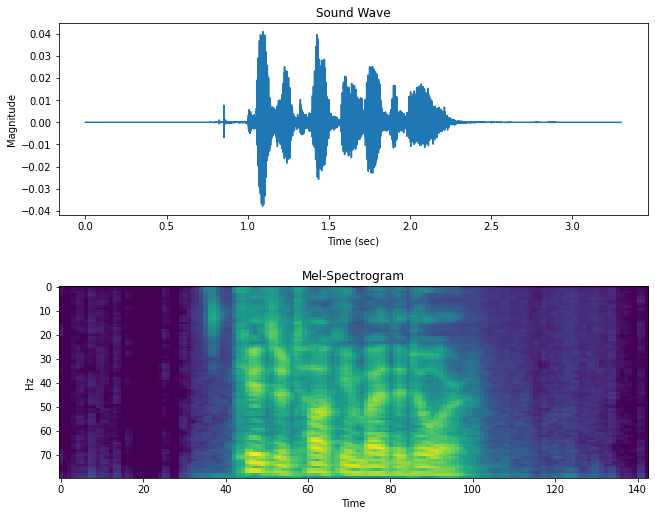

In [5]:
plot_melspec(sig, fs)

#   **Remove Silence Part of Speech by Using "Trim" Module in "Librosa"**

In [6]:
sig_1 = librosa.effects.trim(sig, top_db = 20)[0]

print(f'lenngh: {len(sig_1)/fs:.2f}')
ipd.Audio(data = sig_1, rate = fs)

lenngh: 1.23


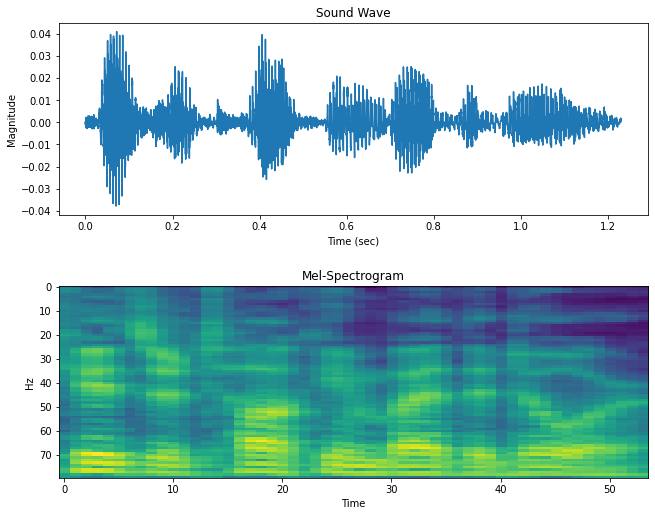

In [7]:
plot_melspec(sig_1, fs)

#   **Remove Silence Part of Speech by Using "Split On Silence" Module in "Pydub"**

In [8]:
# !pip install malaya_speech
# !pip install pydub
import malaya_speech
from pydub import AudioSegment
from pydub.silence import split_on_silence

In [9]:
sig_int = malaya_speech.astype.float_to_int(sig)
audio = AudioSegment(sig_int.tobytes(), frame_rate = fs, sample_width = sig_int.dtype.itemsize, channels = 1)
audio_chunks = split_on_silence(audio, min_silence_len = 100, silence_thresh = -30, keep_silence = 25, seek_step = 1)
sig_2 = sum(audio_chunks)
sig_2 = np.array(sig_2.get_array_of_samples())
sig_2 = malaya_speech.astype.int_to_float(sig_2)

In [10]:
print(f'lenngh: {len(sig_2)/fs:.2f}')
ipd.Audio(data = sig_2, rate = fs)

lenngh: 1.19


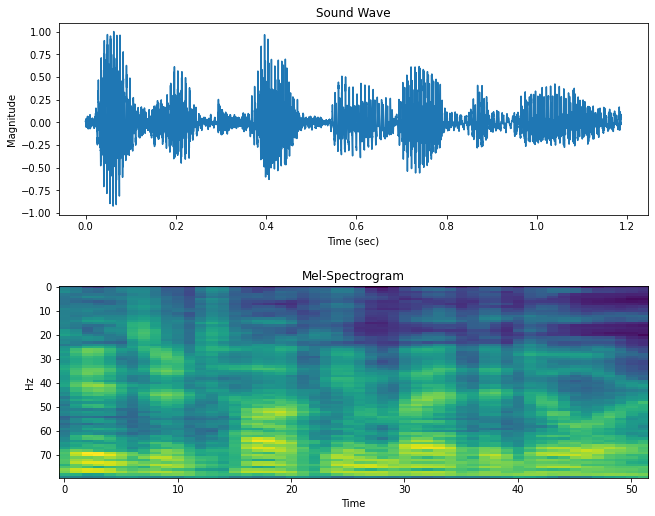

In [11]:
plot_melspec(sig_2, fs)

#   **Plot Fundamental Frequency (F0) on Mel-Spectrogram - Using Probabilistic YIN Algorithm**

In [12]:
import librosa.display as libdis

def plot_pitch(sig):
    f0, voiced_flag, voiced_probs = librosa.pyin(sig, fmin = librosa.note_to_hz('C2'), fmax = librosa.note_to_hz('C7'))
    times = librosa.times_like(f0)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sig)), ref = np.max)
    fig, ax = plt.subplots()
    img = libdis.specshow(D, x_axis = 'time', y_axis = 'log', ax = ax)
    ax.set(title = 'pYIN fundamental frequency estimation')
    fig.colorbar(img, ax = ax, format = "%+2.f dB")
    ax.plot(times, f0, label = 'F0', color = 'cyan', linewidth = 3)
    ax.legend(loc = 'upper right')
    plt.show()

#   **Original Audio**

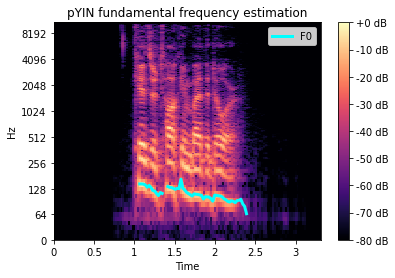

In [13]:
plot_pitch(sig)

#   **Removed Silence Audio (librosa - trim)**

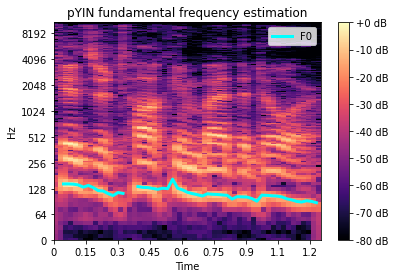

In [14]:
plot_pitch(sig_1)

#   **Removed Silence Audio (pydub - split on silence)**

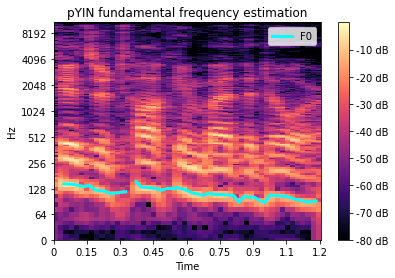

In [15]:
plot_pitch(sig_2)

#   **Print F0 from Each Audio**

In [16]:
f0,_ ,_ = librosa.pyin(sig, fmin = librosa.note_to_hz('C2'), fmax = librosa.note_to_hz('C7'))
print(f0[~np.isnan(f0)])
f0,_ ,_ = librosa.pyin(sig_1, fmin = librosa.note_to_hz('C2'), fmax = librosa.note_to_hz('C7'))
print(f0[~np.isnan(f0)])
f0,_ ,_ = librosa.pyin(sig_2, fmin = librosa.note_to_hz('C2'), fmax = librosa.note_to_hz('C7'))
print(f0[~np.isnan(f0)])

[145.98669166 145.98669166 145.14587019 141.83073393 133.8703865
 140.20166901 132.33275397 122.05264193 120.65074777 112.57112812
 106.86851353 115.86971396 113.22324603 136.21039964 133.09934981
 132.33275397 129.31026969 126.35681905 130.05935646 128.56549734
 165.76853496 130.05935646 124.18608453 116.54094038 112.57112812
 109.36644662 105.64102396 111.92276613 110.63722352 110.
 108.73654224 107.48759653  97.4344271  103.82617439 103.22817963
 102.63362907  98.56656061  91.96585291 108.11026584 107.48759653
 106.25299618 105.64102396 103.22817963  97.998859    95.20902171
  91.43616858  89.86534993  93.03444465  91.43616858  88.321517
  93.5733877   94.11545283  96.8732461   85.3129619   80.06092506
  65.7852867 ]
[145.98669166 145.98669166 145.14587019 141.83073393 133.8703865
 140.20166901 132.33275397 122.05264193 120.65074777 112.57112812
 106.86851353 115.86971396 113.22324603 136.21039964 133.09934981
 132.33275397 129.31026969 126.35681905 130.05935646 128.56549734
 165.76

#   **Applying All-Pass First-Order Filter**

In [17]:
import scipy

def first_order(x, alpha):
    b = [-alpha, 1.0]
    a = [1.0, alpha]
    y = scipy.signal.lfilter(b, a, x)
    w, h = scipy.signal.freqz(b, a)
    return y, w, h

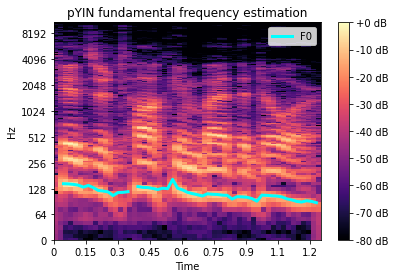

[146.83238396 145.98669166 144.30989149 141.01384901 133.8703865
 140.20166901 132.33275397 122.75968569 120.65074777 117.89508088
 106.86851353 115.86971396 116.54094038 118.57804013 136.21039964
 133.09934981 132.33275397 129.31026969 125.62905732 130.05935646
 128.56549734 164.81377846 130.05935646 124.18608453 116.54094038
 112.57112812 109.36644662 105.64102396 111.92276613 110.63722352
 110.         108.11026584 107.48759653  97.4344271  103.82617439
 103.22817963 102.04250286  98.56656061  91.96585291 108.11026584
 107.48759653 106.25299618 105.64102396 103.22817963  97.998859
  95.20902171  91.43616858  89.86534993  93.03444465  91.43616858
  88.321517  ]


In [18]:
alpha = -.5
filt_sig,_ ,_ = first_order(sig_1, alpha)
plot_pitch(filt_sig)
f0,_ ,_ = librosa.pyin(filt_sig, fmin = librosa.note_to_hz('C2'), fmax = librosa.note_to_hz('C7'))
print(f0[~np.isnan(f0)])

#   **Applying Pitch Shifter by Using Librosa Pitch Shifter ((fractional) half-steps shift)**

In [19]:
sig_pitch_shifted = librosa.effects.pitch_shift(sig_1, fs, n_steps = 5.4)
print(f'lenngh: {len(sig_pitch_shifted)/fs:.2f}')
ipd.Audio(data = sig_pitch_shifted, rate = fs)

lenngh: 1.23


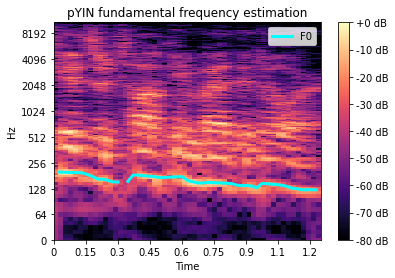

[200.57894748 199.42369775 198.27510177 198.27510177 197.13312122
 194.8688542  186.0688893  176.64303401 165.76853496 165.76853496
 160.12185011 153.77669276 153.77669276 156.464662   184.99721136
 184.99721136 181.81906999 179.73069986 178.6955272  174.61411572
 172.60850154 174.61411572 175.625645   176.64303401 176.64303401
 160.12185011 154.66751208 150.26442824 149.39896882 152.0104168
 151.13490122 150.26442824 149.39896882 148.53849408 146.83238396
 141.01384901 139.39416681 140.20166901 137.79308825 131.57057339
 147.68297531 146.83238396 145.14587019 143.47872767 141.01384901
 136.99945846 130.81278265 128.56549734 124.9054872  124.9054872
 124.9054872  124.9054872 ]


In [20]:
plot_pitch(sig_pitch_shifted)
f0,_ ,_ = librosa.pyin(sig_pitch_shifted, fmin = librosa.note_to_hz('C2'), fmax = librosa.note_to_hz('C7'))
print(f0[~np.isnan(f0)])